<a href="https://colab.research.google.com/github/ambideXtrous9/PyTorch-Models/blob/main/Flickr27_Xception_PyTorchLightning%2BTPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imutils
!pip install wget
!pip install split-folders
!pip install timm
!pip install pytorch-lightning
!pip install torchmetrics
!pip install rich
!pip install --upgrade pytorch-lightning

In [2]:
! pip install cloud-tpu-client==0.10 torch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0 torchtext==0.10.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl (149.9 MB)


In [3]:
%load_ext tensorboard

In [4]:
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import splitfolders
from torch import nn
import numpy as np
import os
import torchmetrics
import timm
import wget
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks import TQDMProgressBar
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import cv2
import tensorflow as tf
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

## Downloading Dataset

In [5]:
_URL = 'http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz'
wget.download(_URL)

'flickr_logos_27_dataset.tar (1).gz'

In [6]:
!ls

 data				       flickr_logos_27_dataset.tar.gz
 flickr_logos_27_dataset	       lightning_logs
 flickr_logos_27_dataset_images        LOGOS
'flickr_logos_27_dataset.tar (1).gz'   sample_data


In [7]:
zip_dir = tf.keras.utils.get_file('./logo', origin=_URL, untar=True,extract=True)

In [8]:
import tarfile

fname = 'flickr_logos_27_dataset.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [9]:
fname = 'flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [10]:
src_dir = "flickr_logos_27_dataset_images"
dest = "LOGOS"

if not os.path.exists(dest):
    os.makedirs(dest)

## Preprocessing

In [11]:
import pandas as pd

In [12]:
df = pd.read_csv("flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt", sep='\s+',header=None)

In [13]:
df

,0,1,2,3,4,5,6
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


In [14]:
X = df.iloc[:,0]
Y = df.iloc[:,1]

In [15]:
dtdir = './flickr_logos_27_dataset_images/'

In [16]:
im = df[0][0]

In [17]:
size = df.iloc[:,3:]

In [18]:
size

,3,4,5,6
0,38,12,234,142
1,242,208,413,331
2,13,5,89,60
3,43,122,358,354
4,83,63,130,93
...,...,...,...,...
4531,15,6,253,54
4532,136,161,304,222
4533,2,4,499,106
4534,1,69,342,157


In [19]:
img = os.path.join(dtdir,im)

In [20]:
size = size.values.tolist()

In [21]:
size[0][0],size[0][1],size[0][2],size[0][3]

(38, 12, 234, 142)

(210, 280, 3)

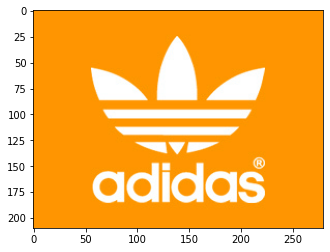

In [22]:
image = cv2.imread(img)
plt.imshow(image)
image.shape

(130, 196, 3)

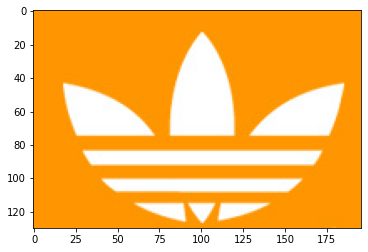

In [23]:
image = cv2.imread(img)
image = image[size[0][1]:size[0][3],size[0][0]:size[0][2]]
plt.imshow(image)
image.shape

In [24]:
query = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_query_set_annotation.txt", sep='\s+',header=None)

In [25]:
query

,0,1
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas
...,...,...
265,3480640208.jpg,none
266,3486224308.jpg,none
267,3486430785.jpg,none
268,3490185235.jpg,none


(500, 437, 3)

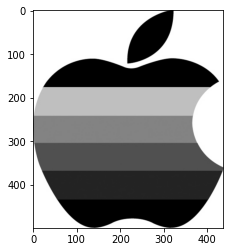

In [26]:
img = os.path.join(dtdir,query[0][5])
image = cv2.imread(img)
plt.imshow(image)
image.shape

In [27]:
y = list(set(list(Y)))
y.sort()

In [ ]:
for i in y:
    os.makedirs(os.path.join(dest,i))

In [ ]:
distractor = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_distractor_set_urls.txt", sep='\s+',header=None)

In [ ]:
distractor

In [29]:
HEIGHT = 224
WIDTH =  224
BS = 256

## Removing Corrupt Images 

In [ ]:
for i in range(len(X)):
    try:
        destrain = os.path.join(dest,Y[i])
        savepath = os.path.join(destrain,X[i])
        img  = os.path.join(dtdir,X[i])
        image = cv2.imread(img)
        image = image[size[i][1]:size[i][3],size[i][0]:size[i][2]]
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass

In [ ]:
A = query.iloc[:,0]
B = query.iloc[:,1]

In [ ]:
A

In [ ]:

for i in range(len(A)):
    try:
        destrain = os.path.join(dest,B[i])
        savepath = os.path.join(destrain,A[i])
        img  = os.path.join(dtdir,A[i])
        image = cv2.imread(img)
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass


In [ ]:
imagePaths = list(paths.list_images(dest))

In [ ]:
img = imagePaths[40]
print(img)
image = cv2.imread(img)
plt.imshow(image)
image.shape

## Train Val Split

In [ ]:
path = 'LOGOS'

In [ ]:
splitfolders.ratio(path, output="data", seed=42, ratio=(0.8,0.2))

## Image Augmentation

In [30]:
# initialize our data augmentation functions
resize = transforms.Resize(size=(WIDTH,HEIGHT))
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)
coljtr = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1)
raf = transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0)
rrsc = transforms.RandomResizedCrop(size=WIDTH, scale=(0.8, 1.0))
ccp  = transforms.CenterCrop(size=WIDTH)  # Image net standards
nrml = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])  # Imagenet standards

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1344: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1358: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


In [31]:
# initialize our training and validation set data augmentation
# pipeline
trainTransforms = transforms.Compose([resize,hFlip,vFlip,rotate,raf,rrsc,ccp,coljtr,transforms.ToTensor(),nrml])
valTransforms = transforms.Compose([resize,hFlip,vFlip,rotate,raf,rrsc,ccp,coljtr,transforms.ToTensor(),nrml])

In [32]:
# initialize the training and validation dataset
print("[INFO] loading the training and validation dataset...")
trainDataset = ImageFolder(root='./data/train',transform=trainTransforms)
valDataset = ImageFolder(root='./data/val', transform=valTransforms)
print("[INFO] training dataset contains {} samples...".format(len(trainDataset)))
print("[INFO] validation dataset contains {} samples...".format(len(valDataset)))

[INFO] loading the training and validation dataset...
[INFO] training dataset contains 755 samples...
[INFO] validation dataset contains 189 samples...


In [33]:
class LitNeuralNet(pl.LightningModule):
    def __init__(self,num_classes):
        super(LitNeuralNet, self).__init__()
        
        
        self.model = timm.create_model('xception', pretrained=True)
        self.model.aux_logits=False

        # Freeze training for all layers
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.fc = nn.Sequential(
                      nn.Linear(self.model.fc.in_features, 256), 
                      nn.Dropout(0.5),
                      nn.ReLU(inplace=True),
                      nn.BatchNorm1d(256),
                      nn.Linear(256, num_classes),
                      nn.LogSoftmax(dim=1))
        # add metrics
        self.train_acc = torchmetrics.Accuracy()
        self.train_f1 = torchmetrics.F1Score(number_classes=num_classes,average="micro")
        self.train_auroc = torchmetrics.AUROC(number_classes=num_classes,average="micro")
        self.val_acc = torchmetrics.Accuracy()
        self.val_f1 = torchmetrics.F1Score(number_classes=num_classes,average="micro")
        self.val_auroc = torchmetrics.AUROC(number_classes=num_classes,average="micro")
        
    def forward(self, x):
        out = self.model(x)
        return out

    def training_step(self, batch, batch_idx):
        images, labels = batch
        # Forward pass
        outputs = self.forward(images)
        lossfn = nn.NLLLoss()
        loss = lossfn(outputs, labels)
        
        y_pred = torch.exp(outputs)
        #y_pred = output.data.max(1, keepdim=True)[1]
        acc = self.train_acc(y_pred, labels)
        f1 = self.train_f1(y_pred, labels)
        # just accumulate

        self.log("train_loss", loss)
        self.log("train_accuracy", acc)
        self.log("train_f1", f1)
        tensorboard_logs = {'train_loss': loss}
        # use key 'log'
        return {"loss": loss, 'log': tensorboard_logs}

    # define what happens for testing here

    def train_dataloader(self):
        trainDataLoader = DataLoader(trainDataset, num_workers=2,batch_size=BS, shuffle=True)

        return trainDataLoader

    def val_dataloader(self):
        valDataLoader = DataLoader(valDataset, num_workers=2,batch_size=BS,shuffle=False)
        
        return valDataLoader
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        # Forward pass
        outputs = self.forward(images)
        lossfn = nn.NLLLoss()   
        loss = lossfn(outputs, labels)
        
        pred = torch.exp(outputs)
        #pred = output.data.max(1, keepdim=True)[1]
        self.val_acc.update(pred, labels)
        self.val_f1.update(pred, labels)

        self.log("val_loss", loss)
        return {"val_loss": loss}
    
    def training_epoch_end(self, training_step_outputs):
        # compute metrics
        train_accuracy = self.train_acc.compute()
        train_f1 = self.train_f1.compute()
        # log metrics
        self.log("epoch_train_accuracy", train_accuracy)
        self.log("epoch_train_f1", train_f1)
        # reset all metrics
        self.train_acc.reset()
        self.train_f1.reset()
        print(f"\ntraining accuracy: {train_accuracy:.4}, "\
        f"f1: {train_f1:.4}")
        
    def validation_epoch_end(self, outputs):
        # outputs = list of dictionaries
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_accuracy = self.val_acc.compute()
        val_f1 = self.val_f1.compute()
        # log metrics
        self.log("val_accuracy", val_accuracy)
        self.log("val_loss", avg_loss)
        self.log("val_f1", val_f1)
        # reset all metrics
        self.val_acc.reset()
        self.val_f1.reset()
        print(f"\nvalidation accuracy: {val_accuracy:.4} "\
        f"f1: {val_f1:.4}")
        
        tensorboard_logs = {'avg_val_loss': avg_loss}
        # use key 'log'
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters())


In [34]:
# seeding for torch, numpy, stdlib random, including DataLoader workers!
seed_everything(123, workers=True)

early_stopping = EarlyStopping(
    monitor="val_loss",
    stopping_threshold=1e-4,
    divergence_threshold=9.0,
    check_finite=True)

Global seed set to 123


In [35]:
model = LitNeuralNet(num_classes=len(trainDataset.classes))
trainer = Trainer(accelerator="tpu",devices=8,max_epochs=100,log_every_n_steps=2,callbacks=[early_stopping])
trainer.fit(model)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: True, using: 8 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 123
Global seed set to 123
Global seed set to 123
Global seed set to 123
Global seed set to 123
Global seed set to 123
Global seed set to 123
Global seed set to 123

  | Name        | Type     | Params
-----------------------------------------
0 | model       | Xception | 21.3 M
1 | train_acc   | Accuracy | 0     
2 | train_f1    | F1Score  | 0     
3 | train_auroc | AUROC    | 0     
4 | val_acc     | Accuracy | 0     
5 | val_f1      | F1Score  | 0     
6 | val_auroc   | AUROC    | 0     
-----------------------------------------
531 K     Trainable params
20.8 M    Non-trainable 

Sanity Checking: 0it [00:00, ?it/s]


validation accuracy: 0.04167 f1: 0.04167

validation accuracy: 0.0 f1: 0.0
validation accuracy: 0.08333 f1: 0.08333


validation accuracy: 0.08333 f1: 0.08333

validation accuracy: 0.08333 f1: 0.08333

validation accuracy: 0.0 f1: 0.0

validation accuracy: 0.0 f1: 0.0

validation accuracy: 0.04167 f1: 0.04167


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=2). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


validation accuracy: 0.04167 f1: 0.04167
validation accuracy: 0.08333 f1: 0.08333
validation accuracy: 0.08333 f1: 0.08333

validation accuracy: 0.08333 f1: 0.08333


validation accuracy: 0.04167 f1: 0.04167


validation accuracy: 0.125 f1: 0.125

validation accuracy: 0.125 f1: 0.125

validation accuracy: 0.125 f1: 0.125

training accuracy: 0.04211, f1: 0.04211
training accuracy: 0.06316, f1: 0.06316


training accuracy: 0.03158, f1: 0.03158
training accuracy: 0.08421, f1: 0.08421


training accuracy: 0.02105, f1: 0.02105
training accuracy: 0.03158, f1: 0.03158
training accuracy: 0.06316, f1: 0.06316


training accuracy: 0.06316, f1: 0.06316



Validation: 0it [00:00, ?it/s]


validation accuracy: 0.08333 f1: 0.08333
validation accuracy: 0.125 f1: 0.125
validation accuracy: 0.125 f1: 0.125
validation accuracy: 0.1667 f1: 0.1667
validation accuracy: 0.125 f1: 0.125
validation accuracy: 0.1667 f1: 0.1667

validation accuracy: 0.08333 f1: 0.08333

validation accuracy: 0.04167 f1: 0.04167






training accuracy: 0.2, f1: 0.2
training accuracy: 0.1789, f1: 0.1789
training accuracy: 0.1474, f1: 0.1474
training accuracy: 0.1474, f1: 0.1474

training accuracy: 0.1684, f1: 0.1684

training accuracy: 0.1684, f1: 0.1684




training accuracy: 0.1789, f1: 0.1789

training accuracy: 0.1158, f1: 0.1158


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.08333 f1: 0.08333
validation accuracy: 0.125 f1: 0.125
validation accuracy: 0.125 f1: 0.125



validation accuracy: 0.08333 f1: 0.08333
validation accuracy: 0.125 f1: 0.125
validation accuracy: 0.1667 f1: 0.1667

validation accuracy: 0.08333 f1: 0.08333



validation accuracy: 0.1667 f1: 0.1667

training accuracy: 0.3579, f1: 0.3579

training accuracy: 0.3053, f1: 0.3053
training accuracy: 0.3895, f1: 0.3895
training accuracy: 0.2947, f1: 0.2947
training accuracy: 0.2421, f1: 0.2421
training accuracy: 0.3158, f1: 0.3158



training accuracy: 0.3579, f1: 0.3579

training accuracy: 0.3789, f1: 0.3789




Validation: 0it [00:00, ?it/s]


validation accuracy: 0.25 f1: 0.25
validation accuracy: 0.25 f1: 0.25

validation accuracy: 0.08333 f1: 0.08333
validation accuracy: 0.1667 f1: 0.1667
validation accuracy: 0.125 f1: 0.125
validation accuracy: 0.04167 f1: 0.04167




validation accuracy: 0.2083 f1: 0.2083

validation accuracy: 0.1667 f1: 0.1667


training accuracy: 0.4947, f1: 0.4947
training accuracy: 0.3789, f1: 0.3789
training accuracy: 0.4105, f1: 0.4105
training accuracy: 0.4632, f1: 0.4632

training accuracy: 0.4316, f1: 0.4316


training accuracy: 0.5053, f1: 0.5053


training accuracy: 0.4211, f1: 0.4211


training accuracy: 0.4421, f1: 0.4421


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.25 f1: 0.25
validation accuracy: 0.25 f1: 0.25
validation accuracy: 0.25 f1: 0.25

validation accuracy: 0.1667 f1: 0.1667
validation accuracy: 0.125 f1: 0.125



validation accuracy: 0.25 f1: 0.25

validation accuracy: 0.125 f1: 0.125
validation accuracy: 0.125 f1: 0.125



training accuracy: 0.6, f1: 0.6
training accuracy: 0.5474, f1: 0.5474


training accuracy: 0.5474, f1: 0.5474
training accuracy: 0.5895, f1: 0.5895
training accuracy: 0.5789, f1: 0.5789



training accuracy: 0.5579, f1: 0.5579

training accuracy: 0.5474, f1: 0.5474

training accuracy: 0.5368, f1: 0.5368


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.2917 f1: 0.2917
validation accuracy: 0.1667 f1: 0.1667
validation accuracy: 0.1667 f1: 0.1667
validation accuracy: 0.2083 f1: 0.2083


validation accuracy: 0.2917 f1: 0.2917
validation accuracy: 0.25 f1: 0.25


validation accuracy: 0.2917 f1: 0.2917
validation accuracy: 0.1667 f1: 0.1667




training accuracy: 0.6211, f1: 0.6211
training accuracy: 0.6105, f1: 0.6105
training accuracy: 0.6421, f1: 0.6421
training accuracy: 0.6632, f1: 0.6632




training accuracy: 0.5895, f1: 0.5895
training accuracy: 0.6737, f1: 0.6737

training accuracy: 0.6, f1: 0.6

training accuracy: 0.6, f1: 0.6



Validation: 0it [00:00, ?it/s]


validation accuracy: 0.3333 f1: 0.3333
validation accuracy: 0.125 f1: 0.125
validation accuracy: 0.2917 f1: 0.2917
validation accuracy: 0.1667 f1: 0.1667
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.2083 f1: 0.2083
validation accuracy: 0.2083 f1: 0.2083








training accuracy: 0.6737, f1: 0.6737

training accuracy: 0.6421, f1: 0.6421
training accuracy: 0.6526, f1: 0.6526
training accuracy: 0.6842, f1: 0.6842
training accuracy: 0.7895, f1: 0.7895
training accuracy: 0.7263, f1: 0.7263




training accuracy: 0.6105, f1: 0.6105


training accuracy: 0.6, f1: 0.6


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.2083 f1: 0.2083

validation accuracy: 0.1667 f1: 0.1667
validation accuracy: 0.2917 f1: 0.2917

validation accuracy: 0.375 f1: 0.375


validation accuracy: 0.1667 f1: 0.1667
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.4583 f1: 0.4583


validation accuracy: 0.2917 f1: 0.2917


training accuracy: 0.6526, f1: 0.6526
training accuracy: 0.7053, f1: 0.7053
training accuracy: 0.7895, f1: 0.7895
training accuracy: 0.7053, f1: 0.7053

training accuracy: 0.7684, f1: 0.7684
training accuracy: 0.7263, f1: 0.7263
training accuracy: 0.7579, f1: 0.7579






training accuracy: 0.7158, f1: 0.7158


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.2917 f1: 0.2917
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.2917 f1: 0.2917
validation accuracy: 0.2083 f1: 0.2083
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.375 f1: 0.375

validation accuracy: 0.3333 f1: 0.3333


validation accuracy: 0.3333 f1: 0.3333





training accuracy: 0.7895, f1: 0.7895
training accuracy: 0.6632, f1: 0.6632
training accuracy: 0.8, f1: 0.8
training accuracy: 0.8632, f1: 0.8632
training accuracy: 0.7474, f1: 0.7474

training accuracy: 0.7263, f1: 0.7263
training accuracy: 0.8, f1: 0.8






training accuracy: 0.7789, f1: 0.7789


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.2917 f1: 0.2917
validation accuracy: 0.1667 f1: 0.1667
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.4167 f1: 0.4167






validation accuracy: 0.5 f1: 0.5


training accuracy: 0.8421, f1: 0.8421
training accuracy: 0.7263, f1: 0.7263

training accuracy: 0.8316, f1: 0.8316
training accuracy: 0.7789, f1: 0.7789


training accuracy: 0.7368, f1: 0.7368


training accuracy: 0.8211, f1: 0.8211
training accuracy: 0.6842, f1: 0.6842

training accuracy: 0.8105, f1: 0.8105



Validation: 0it [00:00, ?it/s]


validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.375 f1: 0.375

validation accuracy: 0.25 f1: 0.25
validation accuracy: 0.4583 f1: 0.4583

validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.3333 f1: 0.3333
validation accuracy: 0.375 f1: 0.375


validation accuracy: 0.4167 f1: 0.4167




training accuracy: 0.7684, f1: 0.7684
training accuracy: 0.8, f1: 0.8
training accuracy: 0.8947, f1: 0.8947


training accuracy: 0.8632, f1: 0.8632
training accuracy: 0.8842, f1: 0.8842


training accuracy: 0.8, f1: 0.8
training accuracy: 0.7789, f1: 0.7789



training accuracy: 0.7579, f1: 0.7579


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.2917 f1: 0.2917



validation accuracy: 0.4583 f1: 0.4583

validation accuracy: 0.2917 f1: 0.2917
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.4583 f1: 0.4583




training accuracy: 0.8316, f1: 0.8316
training accuracy: 0.8526, f1: 0.8526


training accuracy: 0.8211, f1: 0.8211
training accuracy: 0.7895, f1: 0.7895
training accuracy: 0.8105, f1: 0.8105
training accuracy: 0.8737, f1: 0.8737

training accuracy: 0.7789, f1: 0.7789




training accuracy: 0.8211, f1: 0.8211


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.375 f1: 0.375

validation accuracy: 0.5417 f1: 0.5417

validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.2917 f1: 0.2917


validation accuracy: 0.2083 f1: 0.2083

validation accuracy: 0.5 f1: 0.5



training accuracy: 0.8632, f1: 0.8632
training accuracy: 0.8632, f1: 0.8632

training accuracy: 0.8737, f1: 0.8737

training accuracy: 0.9263, f1: 0.9263

training accuracy: 0.8316, f1: 0.8316
training accuracy: 0.9368, f1: 0.9368



training accuracy: 0.8737, f1: 0.8737

training accuracy: 0.8526, f1: 0.8526


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.375 f1: 0.375


validation accuracy: 0.2917 f1: 0.2917
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.5 f1: 0.5

validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.5417 f1: 0.5417





training accuracy: 0.8737, f1: 0.8737

training accuracy: 0.8526, f1: 0.8526
training accuracy: 0.8842, f1: 0.8842
training accuracy: 0.9684, f1: 0.9684

training accuracy: 0.8737, f1: 0.8737


training accuracy: 0.8737, f1: 0.8737
training accuracy: 0.8526, f1: 0.8526



training accuracy: 0.8421, f1: 0.8421


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.2917 f1: 0.2917
validation accuracy: 0.2917 f1: 0.2917
validation accuracy: 0.2917 f1: 0.2917
validation accuracy: 0.4583 f1: 0.4583

validation accuracy: 0.4583 f1: 0.4583





validation accuracy: 0.4583 f1: 0.4583


training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.8737, f1: 0.8737
training accuracy: 0.8737, f1: 0.8737

training accuracy: 0.8632, f1: 0.8632
training accuracy: 0.9053, f1: 0.9053



training accuracy: 0.8947, f1: 0.8947


training accuracy: 0.8737, f1: 0.8737
training accuracy: 0.9053, f1: 0.9053



Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.5417 f1: 0.5417


validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.4167 f1: 0.4167

validation accuracy: 0.3333 f1: 0.3333
validation accuracy: 0.5417 f1: 0.5417





training accuracy: 0.8421, f1: 0.8421

training accuracy: 0.8526, f1: 0.8526
training accuracy: 0.9263, f1: 0.9263


training accuracy: 0.8632, f1: 0.8632

training accuracy: 0.8842, f1: 0.8842
training accuracy: 0.8526, f1: 0.8526
training accuracy: 0.8737, f1: 0.8737



training accuracy: 0.9579, f1: 0.9579


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.3333 f1: 0.3333
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.375 f1: 0.375

validation accuracy: 0.5833 f1: 0.5833







training accuracy: 0.8842, f1: 0.8842
training accuracy: 0.8842, f1: 0.8842
training accuracy: 0.8842, f1: 0.8842



training accuracy: 0.9053, f1: 0.9053
training accuracy: 0.9158, f1: 0.9158
training accuracy: 0.8632, f1: 0.8632



training accuracy: 0.9579, f1: 0.9579

training accuracy: 0.8737, f1: 0.8737


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.375 f1: 0.375

validation accuracy: 0.5 f1: 0.5


validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.3333 f1: 0.3333
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.5 f1: 0.5





training accuracy: 0.9053, f1: 0.9053

training accuracy: 0.8947, f1: 0.8947
training accuracy: 0.9263, f1: 0.9263
training accuracy: 0.8842, f1: 0.8842


training accuracy: 0.9579, f1: 0.9579


training accuracy: 0.8421, f1: 0.8421
training accuracy: 0.9053, f1: 0.9053


training accuracy: 0.8526, f1: 0.8526


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.375 f1: 0.375



validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.3333 f1: 0.3333





training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9263, f1: 0.9263

training accuracy: 0.8737, f1: 0.8737
training accuracy: 0.8947, f1: 0.8947




training accuracy: 0.9368, f1: 0.9368

training accuracy: 0.9368, f1: 0.9368

training accuracy: 0.8947, f1: 0.8947


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.4583 f1: 0.4583

validation accuracy: 0.5833 f1: 0.5833

validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.5417 f1: 0.5417


validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.375 f1: 0.375


validation accuracy: 0.4167 f1: 0.4167


training accuracy: 0.8526, f1: 0.8526
training accuracy: 0.9158, f1: 0.9158
training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.8737, f1: 0.8737

training accuracy: 0.9368, f1: 0.9368
training accuracy: 0.8947, f1: 0.8947

training accuracy: 0.8632, f1: 0.8632
training accuracy: 0.9684, f1: 0.9684







Validation: 0it [00:00, ?it/s]


validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.5417 f1: 0.5417


validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.6667 f1: 0.6667

validation accuracy: 0.625 f1: 0.625





training accuracy: 0.8947, f1: 0.8947

training accuracy: 0.9579, f1: 0.9579
training accuracy: 0.8737, f1: 0.8737
training accuracy: 0.9263, f1: 0.9263
training accuracy: 0.8947, f1: 0.8947


training accuracy: 0.9368, f1: 0.9368
training accuracy: 0.9474, f1: 0.9474




training accuracy: 0.9368, f1: 0.9368


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.4167 f1: 0.4167

validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.5833 f1: 0.5833



validation accuracy: 0.6667 f1: 0.6667




training accuracy: 0.8421, f1: 0.8421

training accuracy: 0.9684, f1: 0.9684
training accuracy: 0.9053, f1: 0.9053


training accuracy: 0.9579, f1: 0.9579
training accuracy: 0.9053, f1: 0.9053

training accuracy: 0.9579, f1: 0.9579


training accuracy: 0.9474, f1: 0.9474

training accuracy: 0.8947, f1: 0.8947


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.4167 f1: 0.4167

validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.4167 f1: 0.4167

validation accuracy: 0.4583 f1: 0.4583



validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.625 f1: 0.625

validation accuracy: 0.5833 f1: 0.5833


training accuracy: 0.8737, f1: 0.8737
training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9263, f1: 0.9263


training accuracy: 0.9684, f1: 0.9684
training accuracy: 0.8947, f1: 0.8947

training accuracy: 0.9158, f1: 0.9158


training accuracy: 0.9474, f1: 0.9474


training accuracy: 0.9474, f1: 0.9474


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5417 f1: 0.5417

validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.375 f1: 0.375

validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.625 f1: 0.625
validation accuracy: 0.5417 f1: 0.5417






training accuracy: 0.9579, f1: 0.9579
training accuracy: 0.9053, f1: 0.9053


training accuracy: 0.9263, f1: 0.9263
training accuracy: 0.9368, f1: 0.9368

training accuracy: 0.9579, f1: 0.9579
training accuracy: 0.8737, f1: 0.8737

training accuracy: 0.9263, f1: 0.9263
training accuracy: 0.9263, f1: 0.9263





Validation: 0it [00:00, ?it/s]


validation accuracy: 0.625 f1: 0.625
validation accuracy: 0.625 f1: 0.625


validation accuracy: 0.625 f1: 0.625
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.5417 f1: 0.5417




validation accuracy: 0.5 f1: 0.5


training accuracy: 0.9579, f1: 0.9579
training accuracy: 0.9684, f1: 0.9684
training accuracy: 0.8947, f1: 0.8947

training accuracy: 0.9474, f1: 0.9474

training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9368, f1: 0.9368

training accuracy: 0.9474, f1: 0.9474

training accuracy: 0.8737, f1: 0.8737





Validation: 0it [00:00, ?it/s]


validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.5417 f1: 0.5417

validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.4167 f1: 0.4167

validation accuracy: 0.625 f1: 0.625
validation accuracy: 0.2917 f1: 0.2917






training accuracy: 0.9789, f1: 0.9789
training accuracy: 0.9158, f1: 0.9158
training accuracy: 0.9789, f1: 0.9789

training accuracy: 0.9579, f1: 0.9579



training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9263, f1: 0.9263

training accuracy: 0.9474, f1: 0.9474




Validation: 0it [00:00, ?it/s]


validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.5 f1: 0.5

validation accuracy: 0.625 f1: 0.625
validation accuracy: 0.4167 f1: 0.4167


validation accuracy: 0.5833 f1: 0.5833





training accuracy: 0.9263, f1: 0.9263
training accuracy: 0.9368, f1: 0.9368
training accuracy: 0.9368, f1: 0.9368



training accuracy: 0.9684, f1: 0.9684
training accuracy: 0.9053, f1: 0.9053

training accuracy: 0.9474, f1: 0.9474


training accuracy: 0.9789, f1: 0.9789

training accuracy: 0.9368, f1: 0.9368


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.625 f1: 0.625
validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.5833 f1: 0.5833

validation accuracy: 0.7083 f1: 0.7083







training accuracy: 0.9158, f1: 0.9158
training accuracy: 0.9579, f1: 0.9579


training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9368, f1: 0.9368
training accuracy: 0.9368, f1: 0.9368
training accuracy: 0.9684, f1: 0.9684


training accuracy: 0.9684, f1: 0.9684

training accuracy: 0.9158, f1: 0.9158




Validation: 0it [00:00, ?it/s]


validation accuracy: 0.3333 f1: 0.3333

validation accuracy: 0.5833 f1: 0.5833

validation accuracy: 0.5417 f1: 0.5417

validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.5417 f1: 0.5417

validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.5 f1: 0.5




training accuracy: 0.9579, f1: 0.9579
training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9158, f1: 0.9158
training accuracy: 0.9368, f1: 0.9368



training accuracy: 0.9789, f1: 0.9789
training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9579, f1: 0.9579




training accuracy: 0.9158, f1: 0.9158


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5 f1: 0.5

validation accuracy: 0.4167 f1: 0.4167

validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.5 f1: 0.5

validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.3333 f1: 0.3333


validation accuracy: 0.375 f1: 0.375


validation accuracy: 0.5417 f1: 0.5417

training accuracy: 0.8947, f1: 0.8947
training accuracy: 1.0, f1: 1.0
training accuracy: 0.9684, f1: 0.9684
training accuracy: 0.9684, f1: 0.9684


training accuracy: 0.9263, f1: 0.9263



training accuracy: 0.9684, f1: 0.9684
training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9684, f1: 0.9684




Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.625 f1: 0.625



validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.6667 f1: 0.6667





training accuracy: 0.9789, f1: 0.9789
training accuracy: 0.8842, f1: 0.8842
training accuracy: 0.9263, f1: 0.9263

training accuracy: 0.9895, f1: 0.9895

training accuracy: 0.9789, f1: 0.9789
training accuracy: 0.9579, f1: 0.9579

training accuracy: 0.9263, f1: 0.9263

training accuracy: 0.9684, f1: 0.9684





Validation: 0it [00:00, ?it/s]


validation accuracy: 0.6667 f1: 0.6667
validation accuracy: 0.625 f1: 0.625

validation accuracy: 0.5 f1: 0.5

validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.3333 f1: 0.3333
validation accuracy: 0.5 f1: 0.5






training accuracy: 0.9684, f1: 0.9684
training accuracy: 0.9263, f1: 0.9263
training accuracy: 0.9263, f1: 0.9263
training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9895, f1: 0.9895

training accuracy: 0.9474, f1: 0.9474


training accuracy: 0.9684, f1: 0.9684




training accuracy: 0.9895, f1: 0.9895


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.625 f1: 0.625
validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.5 f1: 0.5

validation accuracy: 0.5 f1: 0.5


validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.5 f1: 0.5

validation accuracy: 0.375 f1: 0.375




training accuracy: 0.9579, f1: 0.9579
training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9789, f1: 0.9789

training accuracy: 0.9579, f1: 0.9579

training accuracy: 0.9579, f1: 0.9579

training accuracy: 0.9579, f1: 0.9579



training accuracy: 0.9368, f1: 0.9368

training accuracy: 0.9368, f1: 0.9368


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.625 f1: 0.625
validation accuracy: 0.2083 f1: 0.2083
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.5417 f1: 0.5417



validation accuracy: 0.5 f1: 0.5


validation accuracy: 0.4583 f1: 0.4583



training accuracy: 0.9263, f1: 0.9263
training accuracy: 0.9263, f1: 0.9263


training accuracy: 0.9579, f1: 0.9579
training accuracy: 1.0, f1: 1.0
training accuracy: 0.9789, f1: 0.9789
training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9158, f1: 0.9158


training accuracy: 0.9684, f1: 0.9684





Validation: 0it [00:00, ?it/s]


validation accuracy: 0.3333 f1: 0.3333
validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.4167 f1: 0.4167

validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.625 f1: 0.625







training accuracy: 0.9895, f1: 0.9895

training accuracy: 0.9579, f1: 0.9579
training accuracy: 0.9158, f1: 0.9158
training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9789, f1: 0.9789
training accuracy: 0.9684, f1: 0.9684

training accuracy: 1.0, f1: 1.0




training accuracy: 0.9895, f1: 0.9895



Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.625 f1: 0.625

validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.5 f1: 0.5



validation accuracy: 0.3333 f1: 0.3333
validation accuracy: 0.4167 f1: 0.4167




training accuracy: 0.9684, f1: 0.9684

training accuracy: 0.9158, f1: 0.9158

training accuracy: 0.9684, f1: 0.9684

training accuracy: 0.9789, f1: 0.9789

training accuracy: 0.9684, f1: 0.9684
training accuracy: 0.9684, f1: 0.9684


training accuracy: 0.9895, f1: 0.9895

training accuracy: 0.9684, f1: 0.9684


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.625 f1: 0.625
validation accuracy: 0.4167 f1: 0.4167



validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.625 f1: 0.625
validation accuracy: 0.6667 f1: 0.6667





training accuracy: 0.9684, f1: 0.9684
training accuracy: 0.9895, f1: 0.9895

training accuracy: 0.9684, f1: 0.9684

training accuracy: 0.9579, f1: 0.9579


training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9684, f1: 0.9684


training accuracy: 0.9789, f1: 0.9789
training accuracy: 0.9579, f1: 0.9579



Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.375 f1: 0.375
validation accuracy: 0.5417 f1: 0.5417

validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.625 f1: 0.625


validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.4583 f1: 0.4583





training accuracy: 0.9368, f1: 0.9368
training accuracy: 0.9579, f1: 0.9579

training accuracy: 1.0, f1: 1.0

training accuracy: 0.9895, f1: 0.9895

training accuracy: 0.9263, f1: 0.9263
training accuracy: 1.0, f1: 1.0

training accuracy: 0.9684, f1: 0.9684



training accuracy: 0.9579, f1: 0.9579


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.4167 f1: 0.4167


validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.4583 f1: 0.4583

validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.625 f1: 0.625

validation accuracy: 0.375 f1: 0.375




training accuracy: 0.9474, f1: 0.9474

training accuracy: 0.9789, f1: 0.9789
training accuracy: 0.9368, f1: 0.9368


training accuracy: 0.9579, f1: 0.9579

training accuracy: 0.9579, f1: 0.9579

training accuracy: 1.0, f1: 1.0
training accuracy: 0.9684, f1: 0.9684


training accuracy: 0.9474, f1: 0.9474


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.375 f1: 0.375

validation accuracy: 0.625 f1: 0.625
validation accuracy: 0.4167 f1: 0.4167

validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.5417 f1: 0.5417

validation accuracy: 0.5417 f1: 0.5417





training accuracy: 0.9895, f1: 0.9895
training accuracy: 0.9895, f1: 0.9895

training accuracy: 0.9895, f1: 0.9895

training accuracy: 0.9579, f1: 0.9579


training accuracy: 0.9789, f1: 0.9789
training accuracy: 0.9579, f1: 0.9579
training accuracy: 0.9789, f1: 0.9789
training accuracy: 0.9684, f1: 0.9684





Validation: 0it [00:00, ?it/s]


validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.4583 f1: 0.4583

validation accuracy: 0.5833 f1: 0.5833
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.4167 f1: 0.4167
validation accuracy: 0.6667 f1: 0.6667
validation accuracy: 0.4583 f1: 0.4583





validation accuracy: 0.4167 f1: 0.4167


training accuracy: 0.9789, f1: 0.9789
training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9684, f1: 0.9684



training accuracy: 0.9579, f1: 0.9579
training accuracy: 0.9474, f1: 0.9474
training accuracy: 0.9474, f1: 0.9474

training accuracy: 0.9684, f1: 0.9684

training accuracy: 0.9895, f1: 0.9895




Validation: 0it [00:00, ?it/s]


validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.625 f1: 0.625
validation accuracy: 0.625 f1: 0.625
validation accuracy: 0.4583 f1: 0.4583
validation accuracy: 0.4167 f1: 0.4167


validation accuracy: 0.4167 f1: 0.4167




validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.8333 f1: 0.8333


training accuracy: 0.9684, f1: 0.9684
training accuracy: 0.9895, f1: 0.9895

training accuracy: 0.9579, f1: 0.9579

training accuracy: 0.9789, f1: 0.9789
training accuracy: 0.9789, f1: 0.9789

training accuracy: 0.9579, f1: 0.9579


training accuracy: 0.9684, f1: 0.9684

training accuracy: 0.9263, f1: 0.9263



Validation: 0it [00:00, ?it/s]


validation accuracy: 0.3333 f1: 0.3333

validation accuracy: 0.5 f1: 0.5
validation accuracy: 0.375 f1: 0.375

validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.75 f1: 0.75
validation accuracy: 0.5417 f1: 0.5417
validation accuracy: 0.5417 f1: 0.5417


validation accuracy: 0.5 f1: 0.5




training accuracy: 1.0, f1: 1.0

training accuracy: 0.9368, f1: 0.9368
training accuracy: 0.9789, f1: 0.9789
training accuracy: 0.9684, f1: 0.9684
training accuracy: 0.9474, f1: 0.9474


training accuracy: 0.9684, f1: 0.9684

training accuracy: 0.9895, f1: 0.9895

training accuracy: 0.9789, f1: 0.9789




## Prediction On Test Images

In [36]:
testimage = list(paths.list_images('./flickr_logos_27_dataset_images'))

In [50]:
def predimg(path):
    from PIL import Image
    image = Image.open(path)
    plt.imshow(image)
    plt.axis("off")
    plt.show() 
    model.eval()
    with torch.no_grad():
      img =  load_img(path)
      mean = [0.485, 0.456, 0.406] 
      std = [0.229, 0.224, 0.225]
      transform_norm = transforms.Compose([transforms.ToTensor(), 
      transforms.Resize((224,224)),transforms.Normalize(mean, std)])
      img_normalized = transform_norm(img).float()
      img_normalized = img_normalized.unsqueeze_(0)
      img = torch.from_numpy(np.asarray(img)).permute(2, 0, 1)
      test_generator = torch.utils.data.DataLoader(img, num_workers=2,batch_size=BS)
      #img = img_normalized#.to(device)
      output = trainer.test(model,test_generator)
      output = torch.exp(output)
      #print(output)
      index = output.data.cpu().numpy().argmax()
      result = list(np.around(output.data.cpu().numpy()*100,1))
      print(result)
      print("PREDICTED CLASS = ",trainDataset.classes[index])

In [ ]:
predimg(testimage[5])

In [ ]:
%tensorboard --logdir /content/lightning_logs